# Speed
1. For a given record, create a chart of time vs. speed.
   - If the record is longer than 120 seconds, use minutes as the time unit.
   - Use "notes played per second" as the speed unit.
2. Create a chart showing the number of notes pressed at the same time. Experiment with different thresholds.

# Speed Solution 
## 1. Chart of Time vs. Speed:
For this part I just used the given libraries to find the speed. The dataframe contains information about each note, including the start and end times of each note.

To calculate the duration of each note. The duration represents the time it takes for each note to be played. Next, I calculated the speed of each note as the reciprocal of the duration (1/duration). This value represents the number of notes played per second. 

In [154]:
from datasets import load_dataset

dataset = load_dataset("roszcz/internship-midi-data-science", split="train")

Found cached dataset parquet (C:/Users/utente/.cache/huggingface/datasets/roszcz___parquet/roszcz--internship-midi-data-science-5506ea35081b41a4/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [155]:
import fortepyan as ff

record = dataset[0]
piece = ff.MidiPiece.from_huggingface(record)
print(piece.df.head())

        end  pitch     start  velocity  duration
0  2.058438     42  1.934219        74  0.124219
1  2.990469     66  1.935573        84  1.054896
2  2.044531     30  1.948229        76  0.096302
3  2.613073     49  2.556146        77  0.056927
4  2.618333     54  2.564844        59  0.053490


In [156]:
p_df = piece.df #dataframe presentation of piece

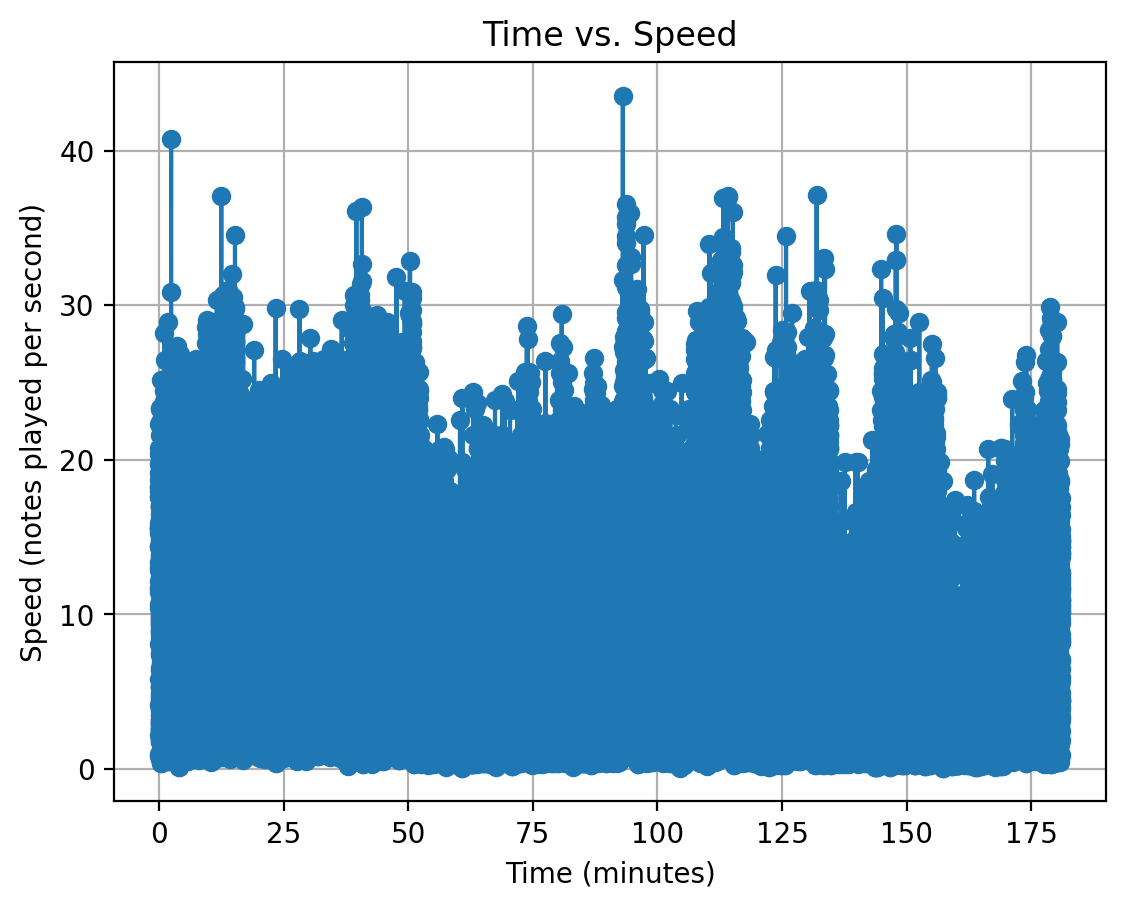

In [157]:
df = p_df.copy()

# Calculate speed (notes played per second)
df['speed'] = 1 / df['duration']

# Convert x-axis to minutes
df['start'] /= 60
df['end'] /= 60

# Plot time vs. speed
plt.plot(df['start'], df['speed'], marker='o', linestyle='-')
plt.xlabel('Time (minutes)')
plt.ylabel('Speed (notes played per second)')
plt.title('Time vs. Speed')
plt.grid(True)
plt.show()

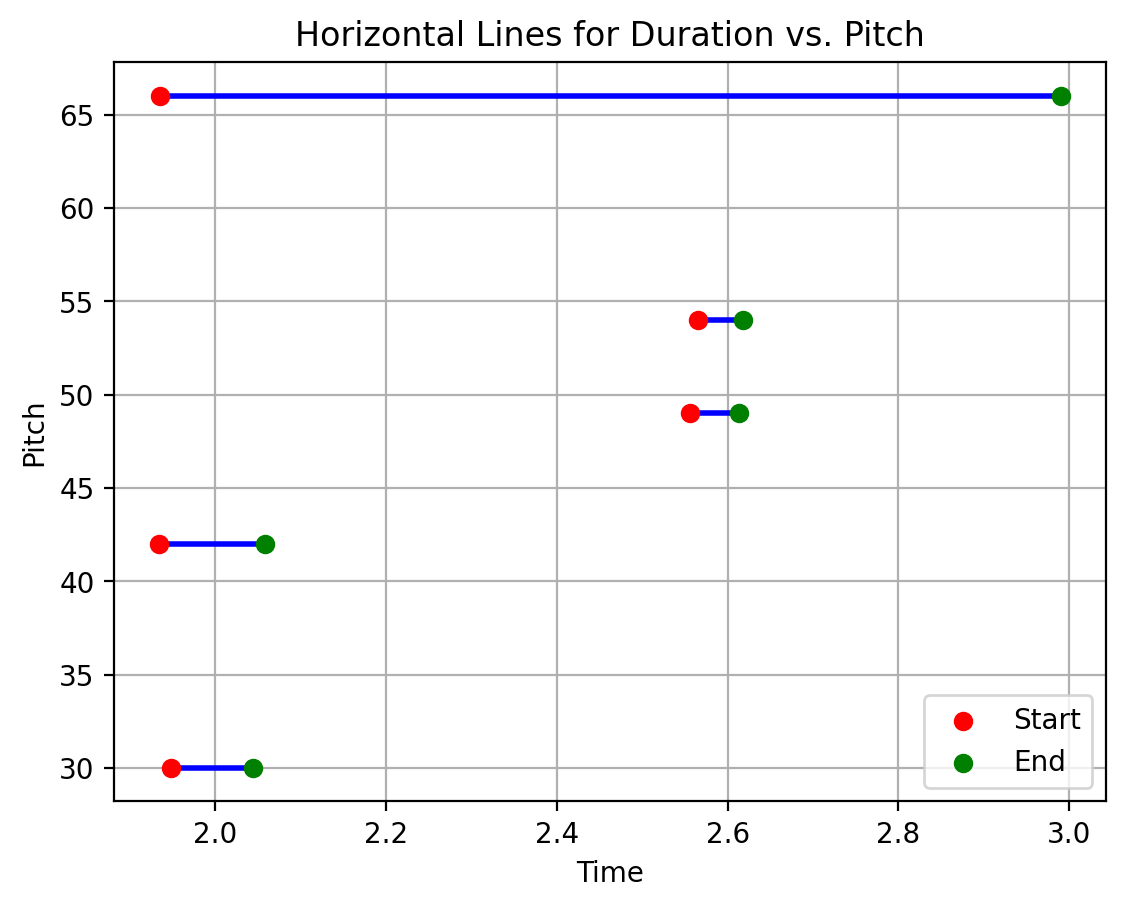

In [158]:
df = p_df[:5].copy()

# Plot horizontal lines for each row
plt.hlines(df['pitch'], df['start'], df['end'], colors='b', lw=2)
plt.scatter(df['start'], df['pitch'], color='r', label='Start', zorder=5)
plt.scatter(df['end'], df['pitch'], color='g', label='End', zorder=5)

plt.xlabel('Time')
plt.ylabel('Pitch')
plt.title('Horizontal Lines for Duration vs. Pitch')
plt.legend()
plt.grid(True)
plt.show()



# Speed 
## 2. Notes pressed at the same time solution
In this part I tried to implement two functions one of them creates intervals and takes the pitches on those intervals. 

The second function just compares start and end times of the events(notes) to calculate number of events at the same time.

In [360]:
import pandas as pd
import matplotlib.pyplot as plt

def count_events_over_time(df, start_time, end_time, time_step):
    # Generate a list of time points from start_time to end_time with the given time_step
    time_points = [start_time + i * time_step for i in range(int((end_time - start_time) / time_step) + 1)]
    
    # Initialize empty lists to store the counts and pitches at each time point
    counts = []
    pitches_list = []
    
    # Iterate through each time point and count the number of events active at that time
    for t in time_points:
        active_events = df[(df['start'] <= t) & (df['end'] >= t)]
        counts.append(len(active_events))
        pitches_list.append(list(active_events['pitch']))

    data = {
        'time_points': time_points,
        'counts': counts,
        'pitches_list': pitches_list
    }
    
    #result_df = pd.DataFrame(data)

    return pd.DataFrame(data)
    
#c_over_time = count_events_over_time(p_df, start_time=0, end_time=p_df['end'].iloc[-1], time_step=1)
# # Create a chart to display the counts over time
# plt.plot(c_over_time[0], c_over_time[1])
# plt.xlabel('Time')
# plt.ylabel('Number of Events')
# plt.title('Number of Events Over Time')
# plt.show()

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

def count_events_over_time_fast(df):
    # Sort the DataFrame by the start time in ascending order
    df = df.sort_values('start')

    # Get the earliest start_time and latest end_time in the DataFrame
    start_time = df['start'].min()
    end_time = df['end'].max()

    # Generate a list of all time points within the range of start_time and end_time
    time_points = sorted(set(df['start']).union(df['end']))

    # Initialize an empty list to store the counts at each time point
    counts = []

    # Create a Counter to track the number of occurrences of each time point
    time_counter = Counter()

    # Iterate through the events
    for _, row in df.iterrows():
        start = row['start']
        end = row['end']

        # Increment the counter for the start time and decrement for the end time
        time_counter[start] += 1
        time_counter[end] -= 1

    # Calculate counts based on the time_counter
    current_count = 0
    for t in time_points:
        current_count += time_counter[t]
        counts.append(current_count)

    data = {
        'time_points': time_points,
        'counts': counts
    }
    
    result_df = pd.DataFrame(data)

    return result_df

# time_points, counts = count_events_over_time_fast(p_df[:10])

# # Plot the step-like, discrete time signal
# plt.plot(time_points, counts, drawstyle='steps-post', marker='o')
# plt.xlabel('Time')
# plt.ylabel('Number of Events')
# plt.title('Number of Events Over Time')
# plt.grid(True)
# plt.show()


In [159]:
all_played_notes = count_events_over_time_fast(p_df)


The number of notes played at the same time never exceeds 10! This delightful reminder in the chart showcases the sweet harmony of music and the charming limitations of our hands.

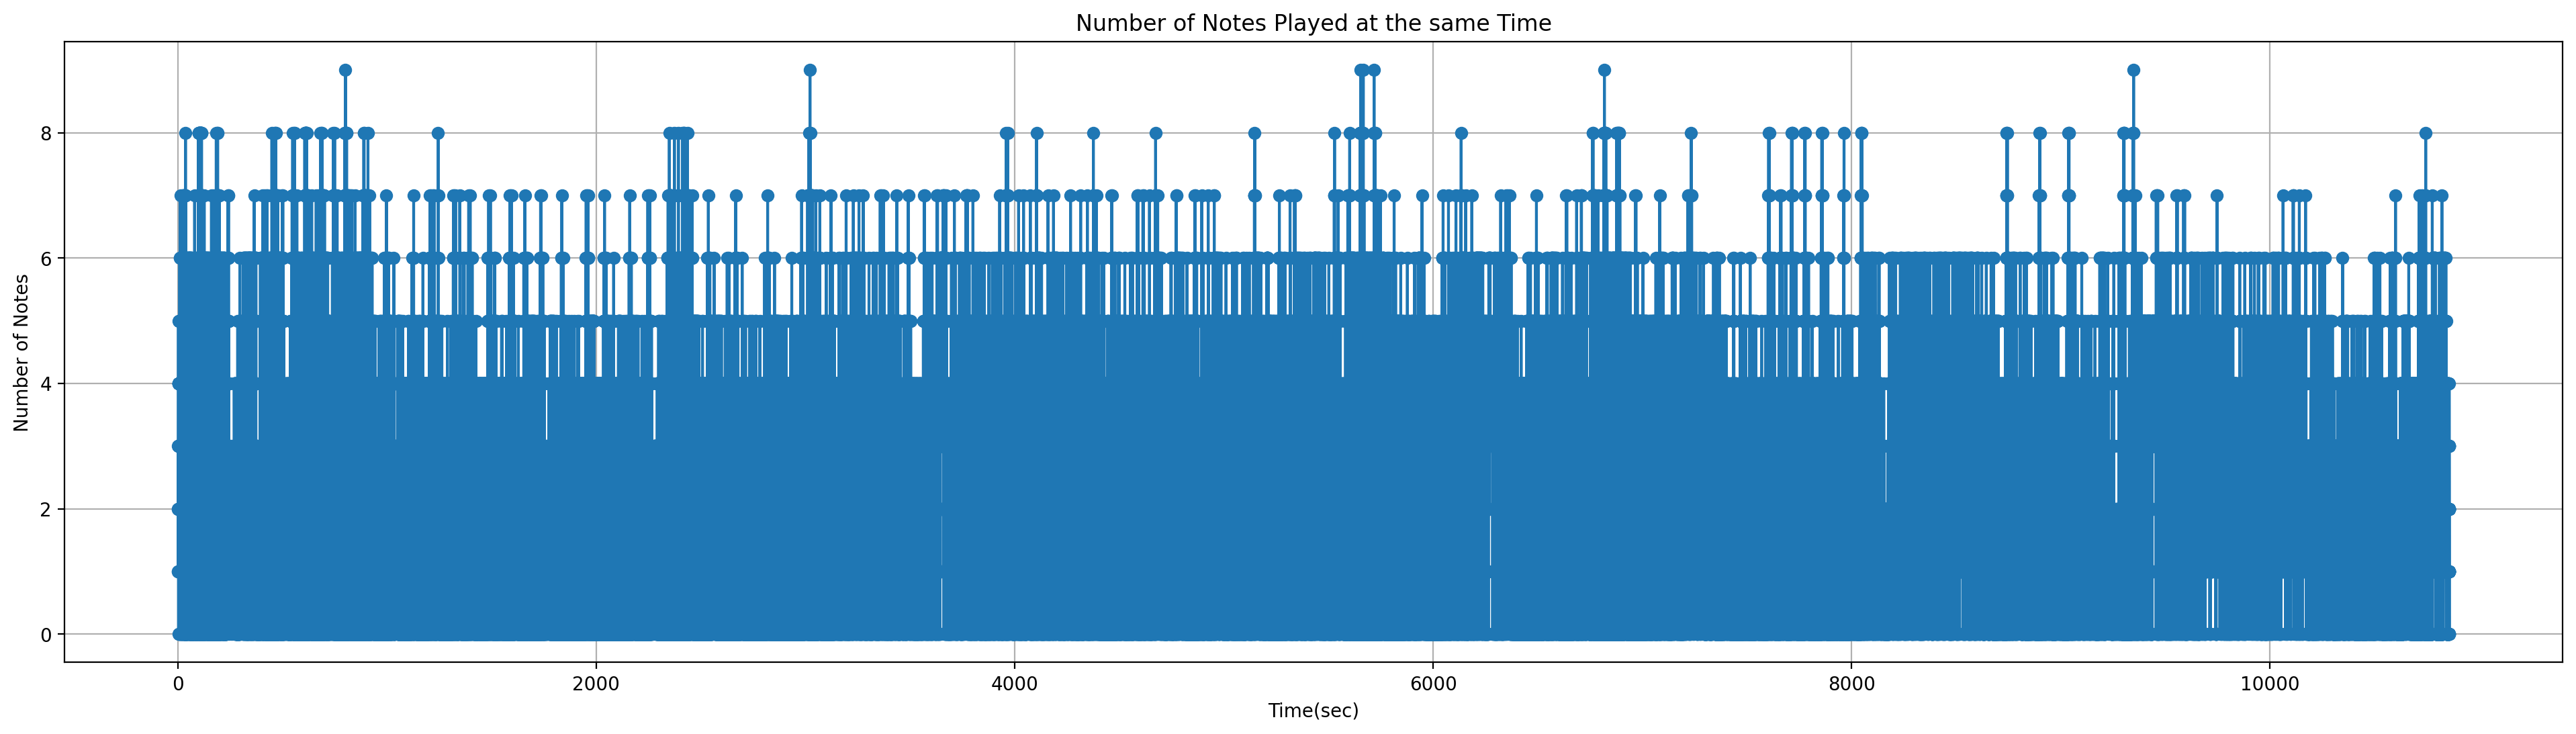

In [168]:
# Plot the step-like, discrete time signal
plt.figure(figsize=(24, 6))

plt.plot(all_played_notes['time_points'], all_played_notes['counts'], drawstyle='steps-post', marker='o')
plt.xlabel('Time(sec)')
plt.ylabel('Number of Notes')
plt.title('Number of Notes Played at the same Time')
plt.grid(True)
plt.show()

In [73]:
filtered = p_df[p_df['duration'] > 0.25]

Also I wanted to visualize which notes played together

In [72]:
def group_pitches_by_start(df, time_threshold):
    # Sort the DataFrame by the 'start' column
    df = df.sort_values('start')

    # Initialize a list to store the grouped data
    grouped_data = []

    # Initialize variables to keep track of the current group
    current_group_start = df['start'].iloc[0]
    current_group_pitches = [df['pitch'].iloc[0]]

    # Helper function to check if the difference between start times is within the threshold
    def within_threshold(start1, start2, threshold):
        return abs(start1 - start2) <= threshold

    # Iterate through the DataFrame and group the pitches based on start times
    for index, row in df.iterrows():
        start_time = row['start']
        pitch = row['pitch']

        if within_threshold(start_time, current_group_start, time_threshold):
            current_group_pitches.append(int(pitch))
        else:
            # If the difference exceeds the threshold, start a new group
            if len(current_group_pitches) >= 2:
                grouped_data.append({'start_time': current_group_start, 'pitches': current_group_pitches})

            current_group_start = start_time
            current_group_pitches = [pitch]

    # Add the last group to the grouped data (if it has at least 2 pitches)
    if len(current_group_pitches) >= 2:
        grouped_data.append({'start_time': current_group_start, 'pitches': current_group_pitches})

    # Create a new DataFrame from the grouped data
    grouped_df = pd.DataFrame(grouped_data)

    return grouped_df


In [88]:
# Call the function with a time threshold of 0.1 for demonstration purposes
time_threshold = 0.01
grouped_df = group_pitches_by_start(filtered, time_threshold)

print(grouped_df)

        start_time         pitches
0         1.935573        [66, 66]
1         9.234375      [66.0, 69]
2         9.809375      [66.0, 63]
3        10.104740      [68.0, 65]
4        10.428021      [69.0, 66]
...            ...             ...
4894  10832.326042  [58.0, 70, 77]
4895  10834.118281      [60.0, 79]
4896  10834.156927      [75.0, 72]
4897  10837.708906  [75.0, 51, 70]
4898  10844.763438      [75.0, 70]

[4899 rows x 2 columns]


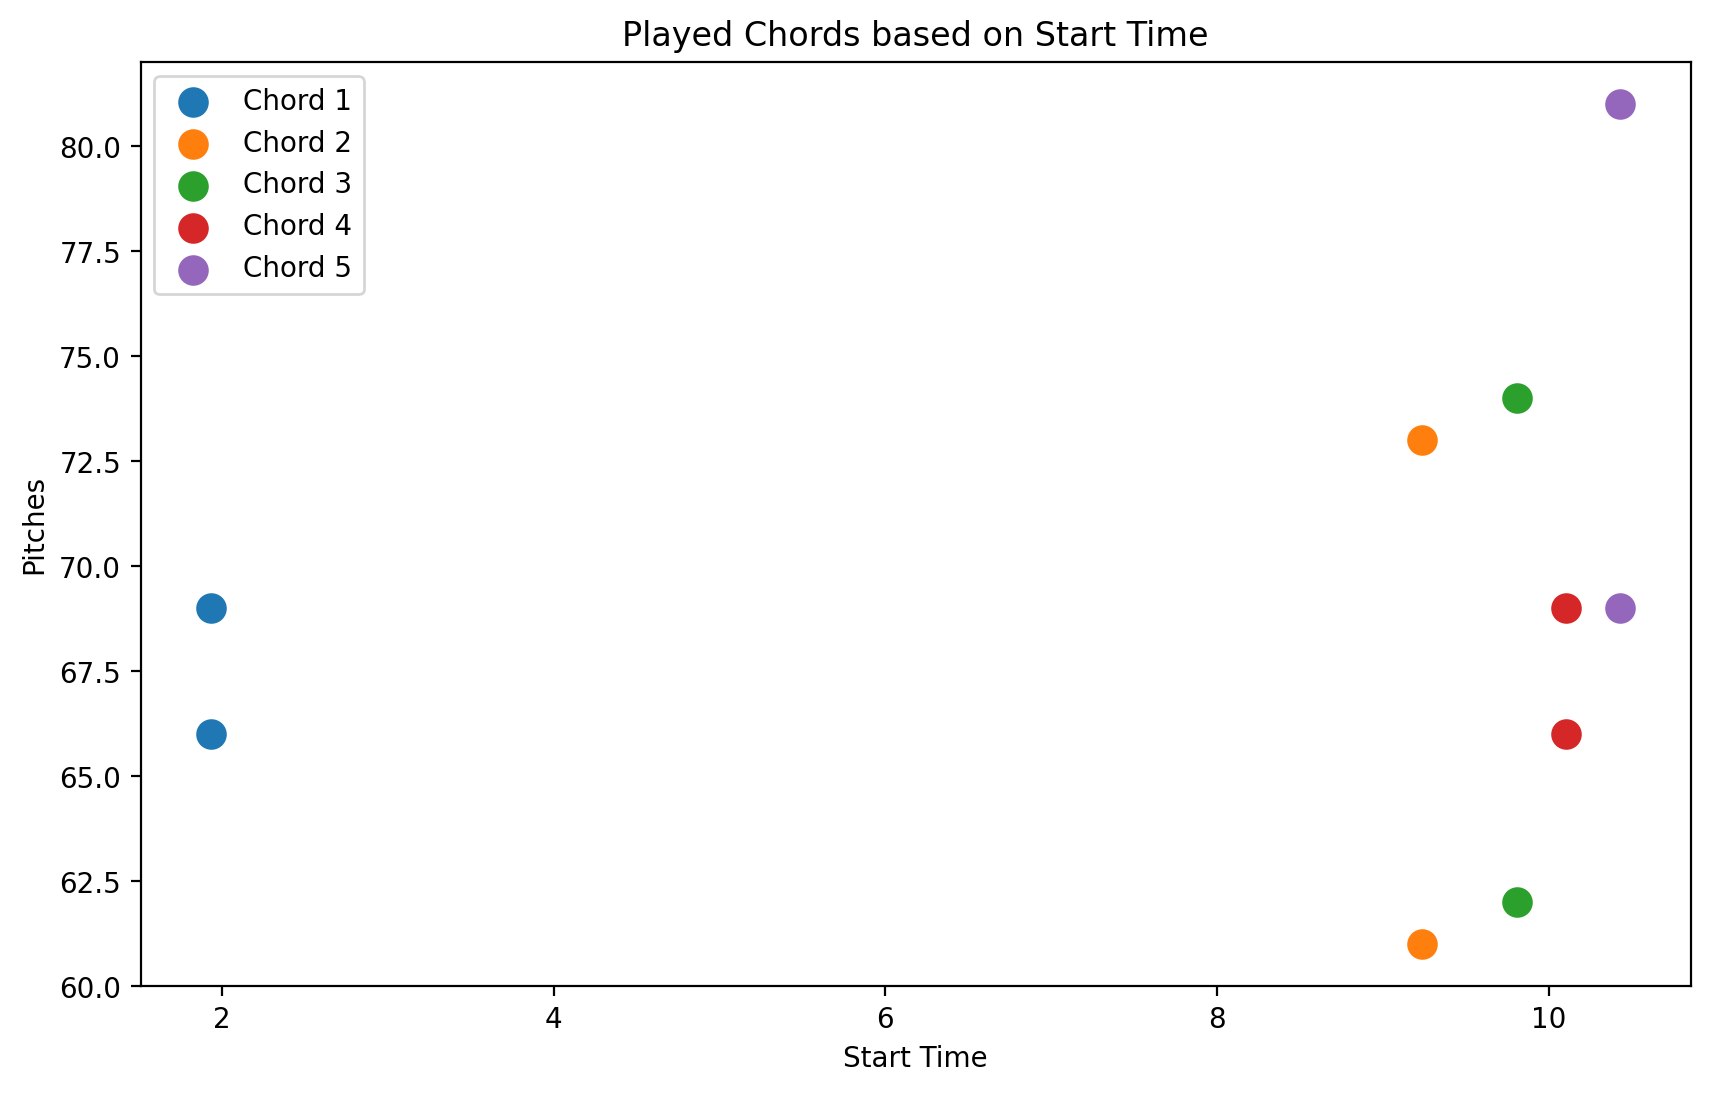

In [169]:
# Plotting the grouped pitches
plt.figure(figsize=(10, 6))
for i, pitches in enumerate(grouped_df['pitches'][5:10]):
    start_time = grouped_df['start_time'].iloc[i]
    plt.scatter([start_time] * len(pitches), pitches, label=f'Chord {i+1}', marker='o', s=100)

plt.xlabel('Start Time')
plt.ylabel('Pitches')
plt.title('Played Chords based on Start Time')
plt.legend()
plt.show()

# Chords
1. For a given record, create a chart of time vs. the number of chords played.
2. Based on chord detection developed for 1., crate a table with the number of occurances of chords.
   - Try to use chorder to assign names to detected notes.
   
Using solutions you developed, review this dataset: https://huggingface.co/datasets/roszcz/maestro-v1, and find:
   1. A piece with the fastest 15 seconds of music
   2. A piece where a single chord is repeated the most (each piece will have a different chord)

# Chords Solutions:
## 1. Number of chords played
In this part I ended up using *music21* library to identify the chords from played pitches. Since this library has very detailed chord detection algorithm everytime I extract chords I needed to filter them out by using their root note and chord type.

Also this library relatively slower than the pretty_midi so all the computationally heavy parts have done on kaggle.com

In [173]:
import music21

In [174]:
#starting from file and read it as midi
def file2mf(fp):
    mf = music21.midi.MidiFile()
    if isinstance(fp, bytes):
        mf.readstr(fp)
    else:
        mf.open(fp)
        mf.read()
        mf.close()
    return mf

#this function transforms midi file to music stream which music21 library can parse and analyze
def mf2stream(mf): return music21.midi.translate.midiFileToStream(mf)

In [205]:
piece_midi = file2mf("MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav.mid")

In [206]:
stream = mf2stream(piece_midi)


In [207]:
# Create an empty list to store the chords
chords_list = []

# Iterate through the midi_stream and extract chords
for element in stream.recurse():
    if isinstance(element, music21.chord.Chord):
        chords_list.append(element)

As you can see music21 directly shows the chords and individual notes thats played on that chord.

In [209]:
chords_list[0:5]

[<music21.chord.Chord B4 C5>,
 <music21.chord.Chord D5 B3>,
 <music21.chord.Chord F#5 B3>,
 <music21.chord.Chord D5 C5 D5>,
 <music21.chord.Chord E4 C5>]

We are more interested in chord names so we create the chord name by taking the root note and chord type to create the common chord name.

In [210]:
chord_names_list = []

# Iterate through the midi_stream and extract chord names (figures)
for element in stream.recurse():
    if isinstance(element, music21.chord.Chord):
        root_name = element.root().name
        common_name = element.commonName
        chord_name = f"{root_name} {common_name}"
        chord_names_list.append(chord_name)

In [211]:
chord_names_list[0:5]

['C Minor Second',
 'B Minor Tenth',
 'B Perfect Twelfth',
 'D Major Second',
 'C Minor Sixth']

In [212]:
def simplify_chords(chord_names_list):
    simplified_chords = []

    for chord_name in chord_names_list:
        # Split the chord name into root and common name (if possible)
        chord_parts = chord_name.split()
        root_name = chord_parts[0]
        common_name = chord_parts[1] if len(chord_parts) > 1 else ""

        # Remove any additional chord extensions or alterations
        simplified_chord_name = f"{root_name} {common_name.split()[0]}"
        simplified_chords.append(simplified_chord_name)

    return simplified_chords

In [213]:
simplified_chords_list = simplify_chords(chord_names_list)

In [215]:
simplified_chords_list[:10]

['C Minor',
 'B Minor',
 'B Perfect',
 'D Major',
 'C Minor',
 'C Major',
 'B Minor',
 'B Minor',
 'E Minor',
 'C# Diminished']

# Speed
## 2. chord frequency chart
We count and sort the chords played throughout the piece and make a plot.

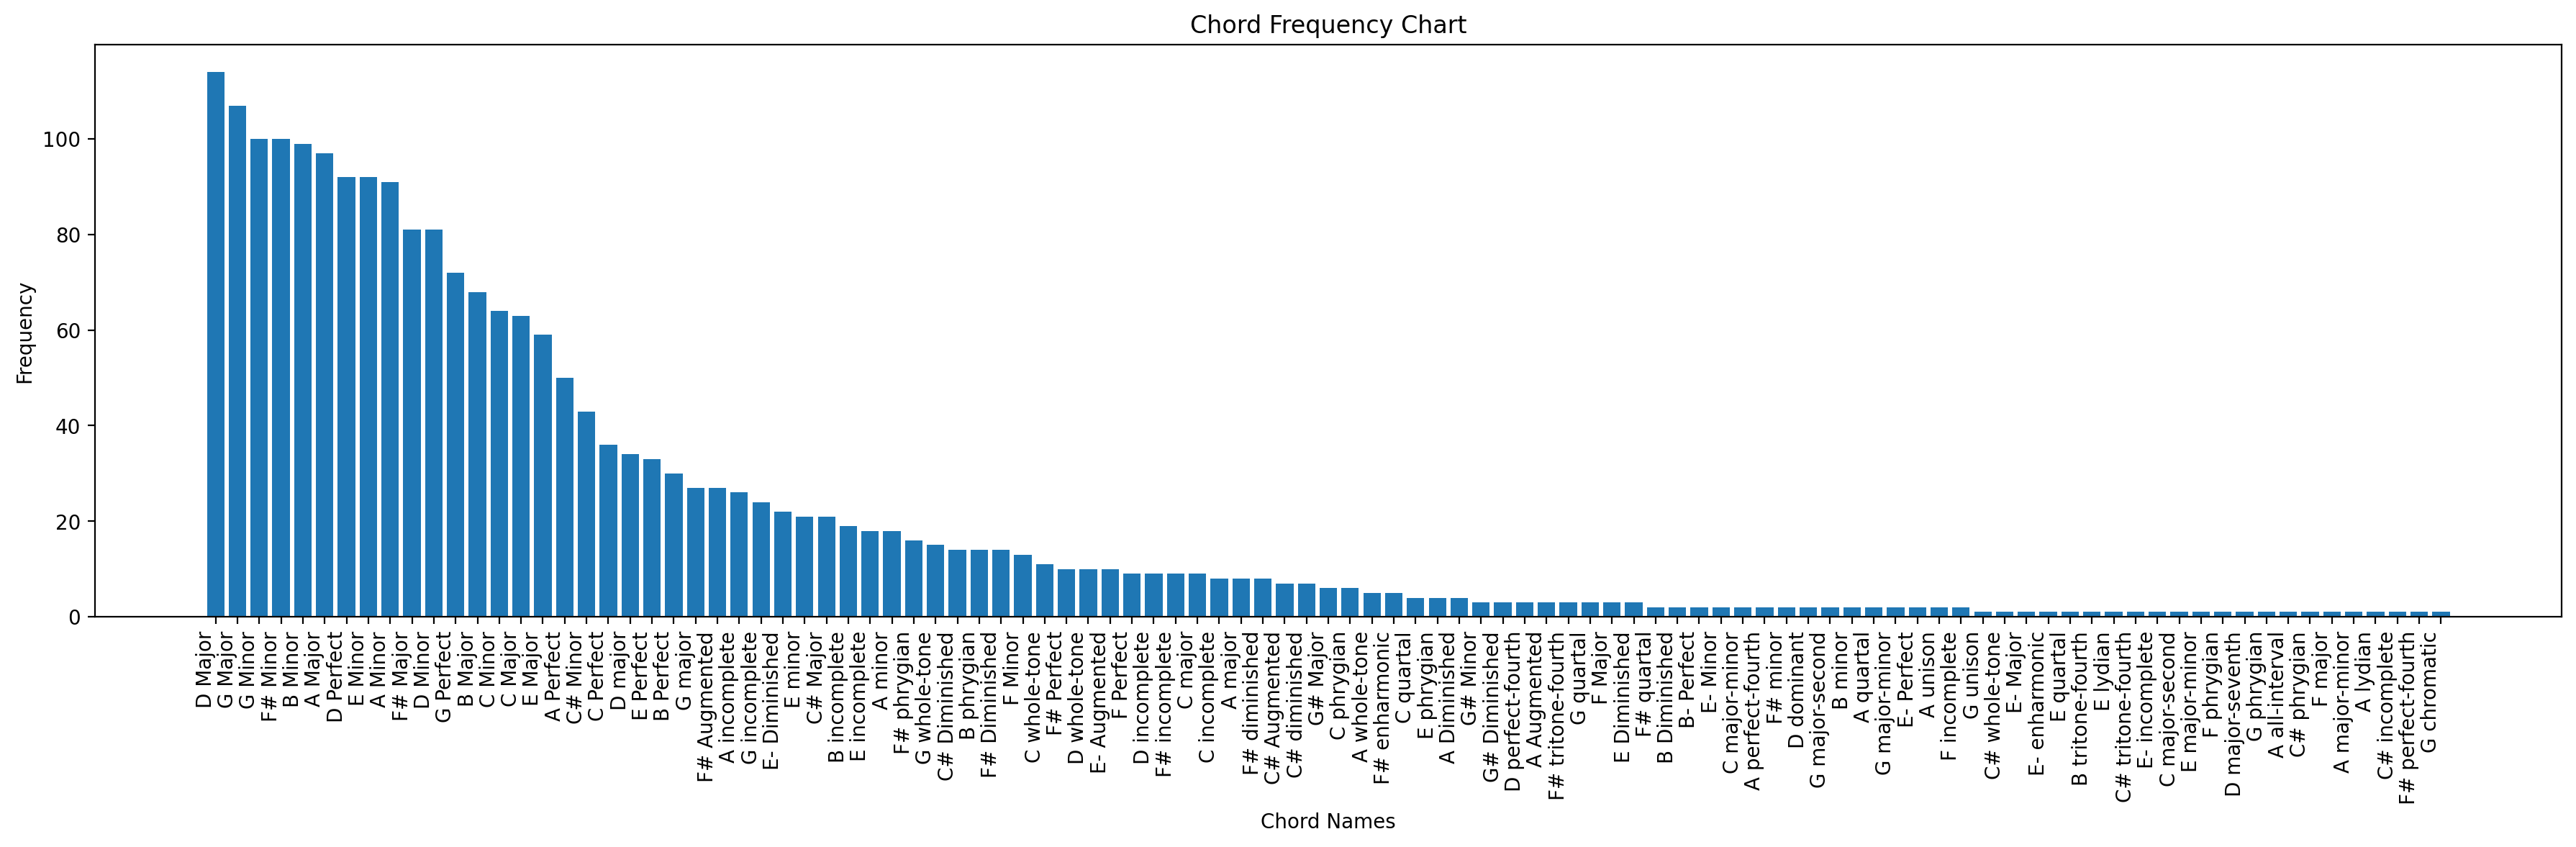

In [216]:
def plot_chord_frequency(chords_list):
    # Count the frequency of each chord in the list
    chord_counts = {chord: chords_list.count(chord) for chord in set(chords_list)}

    # Sort the chords by frequency in descending order
    sorted_chords = sorted(chord_counts.items(), key=lambda x: x[1], reverse=True)

    # Extract chord names and frequencies for plotting
    chord_names, chord_frequencies = zip(*sorted_chords)

    # Create a bar chart to display the frequencies of each chord
    plt.figure(figsize=(18, 6))
    plt.bar(chord_names, chord_frequencies)
    plt.xlabel('Chord Names')
    plt.ylabel('Frequency')
    plt.title('Chord Frequency Chart')
    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()
    plt.show()


plot_chord_frequency(simplified_chords_list)

This function belove is the end to end version of what we have done so far. This function starts from midi, converts it into stream, extracts chords, create simple chord name, count chords per piece and returns chord counts and midi file path of it.

In [217]:
def midi_file_to_chord_frequency_chart(midi_file_path):
    # Step 1: Convert MIDI file to music21 stream
    midi_stream = file2mf(midi_file_path)
    
    midi_stream = mf2stream(midi_stream)
    
    # Create an empty list to store the chords
    chords_list = []

    # Iterate through the midi_stream and extract chords
    for element in midi_stream.recurse():
        if isinstance(element, music21.chord.Chord):
            chords_list.append(element)
    
    chord_names_list = []

    # Iterate through the midi_stream and extract chord names (figures)
    for element in midi_stream.recurse():
        if isinstance(element, music21.chord.Chord):
            root_name = element.root().name
            common_name = element.commonName
            chord_name = f"{root_name} {common_name}"
            chord_names_list.append(chord_name)
            
    

    # Step 3: Simplify the chord names
    simplified_chords_list = simplify_chords(chord_names_list)

    # Step 4: Plot the chord frequency chart
    # Count the frequency of each chord in the list
    chord_counts = {chord: simplified_chords_list.count(chord) for chord in set(simplified_chords_list)}

    # Sort the chords by frequency in descending order
    sorted_chords = sorted(chord_counts.items(), key=lambda x: x[1], reverse=True)

    # Extract chord names and frequencies for plotting
    chord_names, chord_frequencies = zip(*sorted_chords)
    
    return sorted_chords , midi_file_path.split('/')[-1]
    
    #print(sorted_chords[0])

    #Create a bar chart to display the frequencies of each chord
    plt.figure(figsize=(18, 6))
    plt.bar(chord_names, chord_frequencies)
    plt.xlabel('Chord Names')
    plt.ylabel('Frequency')
    plt.title(midi_file_path.split('/')[-1])
    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()
    plt.show()

midi_file_to_chord_frequency_chart('MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav.mid')


([('D Major', 114),
  ('G Major', 107),
  ('G Minor', 100),
  ('F# Minor', 100),
  ('B Minor', 99),
  ('A Major', 97),
  ('D Perfect', 92),
  ('E Minor', 92),
  ('A Minor', 91),
  ('F# Major', 81),
  ('D Minor', 81),
  ('G Perfect', 72),
  ('B Major', 68),
  ('C Minor', 64),
  ('C Major', 63),
  ('E Major', 59),
  ('A Perfect', 50),
  ('C# Minor', 43),
  ('C Perfect', 36),
  ('D major', 34),
  ('E Perfect', 33),
  ('B Perfect', 30),
  ('G major', 27),
  ('F# Augmented', 27),
  ('A incomplete', 26),
  ('G incomplete', 24),
  ('E- Diminished', 22),
  ('E minor', 21),
  ('C# Major', 21),
  ('B incomplete', 19),
  ('E incomplete', 18),
  ('A minor', 18),
  ('F# phrygian', 16),
  ('G whole-tone', 15),
  ('C# Diminished', 14),
  ('B phrygian', 14),
  ('F# Diminished', 14),
  ('F Minor', 13),
  ('C whole-tone', 11),
  ('F# Perfect', 10),
  ('D whole-tone', 10),
  ('E- Augmented', 10),
  ('F Perfect', 9),
  ('D incomplete', 9),
  ('F# incomplete', 9),
  ('C major', 9),
  ('C incomplete', 8),
 

### This part I used kaggle because of parsing 1200 midi files was computationally heavy. I added the results of the dataframe on **chords_played.csv** file.
It took approximately 5 hours to extract all the chords. I think finding the chord notes using pretty_midi than naming them using music21 would be so much faster since the bottleneck of the performance was loading the midi file to music21 to make it stream object.

You can see the kaggle note book [here](https://www.kaggle.com/hakanate/chord-detection-maestro)

In [ ]:
composer_name = []
canonical_name = []
most_freq = []
fq = []
for i in range(len(maestro_df)):
    chart1 = midi_file_to_chord_frequency_chart_from_df(maestro_df.iloc[i])
    #chords_by_midis =  {'midi_file' : chart1[1],'most frequent chord':chart1[0][0][0],'frequency':chart1[0][0][1]}
    composer_name.append(chart1[1])
    most_freq.append(chart1[0][0][0])
    fq.append(chart1[0][0][1])
    canonical_name.append(chart1[2])
    print("%"+str(100*i/len(maestro_df)))

In [ ]:
data = {
    
        'composer_name' : composer_name,
        'canonical_name': canonical_name,
        'most_frequent_chord': most_freq,
        'frequency': fq
    }
chords_df = pd.DataFrame(data)

In [ ]:
chords_df.to_csv('chords_played.csv')

In [226]:
pd.read_csv('chords_played.csv')

,Unnamed: 0,composer_name,canonical_name,most_frequent_chord,frequency
0,0,Alban Berg,Sonata Op. 1,G Major,36
1,1,Alban Berg,Sonata Op. 1,G Major,42
2,2,Alban Berg,Sonata Op. 1,B Perfect,39
3,3,Alexander Scriabin,"24 Preludes Op. 11, No. 13-24",B- Perfect,119
4,4,Alexander Scriabin,"3 Etudes, Op. 65",B Diminished,56
...,...,...,...,...,...
1271,1271,Wolfgang Amadeus Mozart,"Sonata in F Major, K280",G# Augmented,22
1272,1272,Wolfgang Amadeus Mozart,"Sonata in F Major, K280",F Major,32
1273,1273,Wolfgang Amadeus Mozart,"Sonata in F Major, K533",A Major,108
1274,1274,Wolfgang Amadeus Mozart,"Sonata in F Major, K533/K494",C Major,98


In [235]:
sorted_df = pd.read_csv('chords_played.csv',index_col=0).sort_values(by='frequency', ascending=False)


In [236]:
sorted_df

,composer_name,canonical_name,most_frequent_chord,frequency
1092,Modest Mussorgsky,Pictures at an Exhibition,F# Perfect,407
892,Johannes Brahms,"Variations on a Theme by Paganini, Op. 35, Vol...",A Perfect,362
1094,Modest Mussorgsky,Pictures at an Exhibition,F# Perfect,349
887,Johannes Brahms,"Variations and Fugue on the Theme of Händel, O...",F Perfect,338
1090,Modest Mussorgsky,Pictures at an E,F# Perfect,335
...,...,...,...,...
737,Johann Sebastian Bach,"Prelude and Fugue in F-sharp Major, WTC I , B...",G# Major,10
733,Johann Sebastian Bach,Prelude & Fugue,A Perfect,10
1227,Sergei Rachmaninoff,Sonata No. 2 in B-Flat Minor Op. 36 (1913),E Perfect,9
74,Claude Debussy,"Prelude No. 6, Book I, ""Des pas sur la neige""",D Perfect,9


Most frequent chord was F# with 407 times from Modest Mussorgysky on Pictures at an Exhibition

# Fastest 15 seconds

In [1]:
from datasets import load_dataset

dataset = load_dataset("roszcz/maestro-v1", split="train")

c:\Users\utente\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset parquet (C:/Users/utente/.cache/huggingface/datasets/roszcz___parquet/roszcz--maestro-v1-b8e6dde91a93bd23/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [3]:
import fortepyan as ff

record = dataset[0]
piece = ff.MidiPiece.from_huggingface(record)

c:\Users\utente\AppData\Local\Programs\Python\Python311\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [30]:
piece.source['title']

'Sonata Op. 1'

In [31]:
def find_fastest_interval_with_max_notes(piece):
    df = piece.df

    composer = piece.source['composer']
    title = piece.source['title']
    # Find the duration of the DataFrame (total time)
    total_duration = df['end'].max()

    # Define the interval length (15 seconds)
    
    interval_length = 15.0

    # Initialize variables to keep track of the maximum number of notes played and the corresponding interval
    max_notes = 0
    max_notes_interval = None

    # Iterate over the intervals, moving 1 second each time until the end of the piece is reached
    for start_time in range(int(total_duration - interval_length) + 1):
        # Define the end time of the interval
        end_time = start_time + interval_length

        # Filter the DataFrame to get the notes within the current interval
        interval_df = df[(df['start'] >= start_time) & (df['end'] <= end_time)]

        # Count the number of notes in the interval
        num_notes = len(interval_df)

        # Update the maximum number of notes and corresponding interval if applicable
        if num_notes > max_notes:
            max_notes = num_notes
            max_notes_interval = (start_time, end_time)
            max_notes_interval = (start_time, end_time)

    return composer, title, max_notes_interval, max_notes

In [21]:
composer1,piece1,fastest_interval, num_notes = find_fastest_interval_with_max_notes(piece)

# Print the result
print("Fastest 15 seconds interval:")
print(f"Start Time: {fastest_interval[0]} seconds")
print(f"End Time: {fastest_interval[1]} seconds")
print(f"Number of Notes Played: {num_notes}")

Fastest 15 seconds interval:
Start Time: 375 seconds
End Time: 390.0 seconds
Number of Notes Played: 233


In [32]:
composers = []
pieces = []
fastest_intervals = []
num_notes_list= []
for i in range(len(dataset)):
    composer1,piece1,fastest_interval, num_notes = find_fastest_interval_with_max_notes(ff.MidiPiece.from_huggingface(dataset[i]))
    composers.append(composer1)
    pieces.append(piece1)
    fastest_intervals.append(fastest_interval)
    num_notes_list.append(num_notes)


In [26]:
import pandas as pd

In [33]:
data = {
    
        'composer_name' : composers,
        'canonical_name': pieces,
        'fastest_intervals': fastest_intervals,
        'number_of_notes': num_notes_list
    }

speed_df = pd.DataFrame(data)

In [34]:
speed_df.sort_values(by='number_of_notes', ascending=False)

,composer_name,canonical_name,fastest_intervals,number_of_notes
376,Frédéric Chopin,"12 Etudes, Op. 25","(1181, 1196.0)",639
455,Frédéric Chopin,Etude Op. 25 No. 10 in B Minor,"(20, 35.0)",631
454,Frédéric Chopin,Etude Op. 25 No. 10 in B Minor,"(16, 31.0)",599
117,Franz Liszt,"""La Campanella""","(244, 259.0)",599
176,Franz Liszt,Sonata in B Min.,"(1208, 1223.0)",598
...,...,...,...,...
605,Johann Sebastian Bach,"Prelude and Fugue in D Major, WTC II, BWV 874","(95, 110.0)",91
618,Johann Sebastian Bach,"Prelude and Fugue in E-flat Minor WTC I, BWV 853","(378, 393.0)",86
621,Johann Sebastian Bach,"Prelude and Fugue in E-flat Minor, WTC I, BWV 853","(54, 69.0)",84
542,Johann Pachelbel,Chaconne in F Minor,"(118, 133.0)",80
